In [136]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchsummary as ts
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [137]:
T.cuda.empty_cache()
device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [138]:
#def the load data function to load the data
def load_data(file_name):
    data = np.load(file_name)
    return data

In [139]:
def map_func(x):
    x_float = np.zeros((x.shape[0], x.shape[1], 1))
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if x[i][j] == ".":
                x_float[i][j] = 0
            elif x[i][j] == "E":
                x_float[i][j] = 1
            elif x[i][j] == "#":
                x_float[i][j] = 2
            elif x[i][j] == "S":
                x_float[i][j] = 3
            elif x[i][j] == "*":
                x_float[i][j] = 4
    return x_float

In [140]:
#create a inverse of the map_func
def inverse_map_func(x):
    x_float = np.empty((x.shape[0], x.shape[1]), dtype=str)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if round((x[i][j])*2+2) == 0:
                x_float[i][j] = "."
            elif round((x[i][j])*2+2) == 1:
                x_float[i][j] = "E"
            elif round((x[i][j])*2+2) == 2:
                x_float[i][j] = "#"
            elif round((x[i][j])*2+2) == 3:
                x_float[i][j] = "S"
            elif round((x[i][j])*2+2) == 4:
                x_float[i][j] = "*"
            else :
                x_float[i][j] = "?"
    return x_float

In [141]:
mazes = load_data("Mazes.npy")
# split the (100, rows, cols, 2) list into (100, rows, cols) and (100, rows, cols)
x_train = mazes[0]
y_train = mazes[1]
# map the maze to a float array with map_func to a numpy array with a numpy function
x_pro = np.array(list(map(map_func, x_train)))
# map the maze to a float array with map_func to a numpy array with a numpy function
y_pro = np.array(list(map(map_func, y_train)))

In [142]:
x_train = x_pro
y_train = y_pro
# make the data range to -1 to 1 to make it easier to train using tanh
x_train = (x_train / 4)
y_train = (y_train / 4)
x_train = T.from_numpy(x_train).float().to(device)
y_train = T.from_numpy(y_train).float().to(device)
#change size from (100, rows, cols, 1) to (100,1, rows, cols)
x_train = x_train.view(-1, 1, x_train.shape[1], x_train.shape[2])
y_train = y_train.view(-1, 1, y_train.shape[1], y_train.shape[2])
print(x_train.shape)
print(y_train.shape)


torch.Size([9740, 1, 32, 32])
torch.Size([9740, 1, 32, 32])


In [154]:
#transposer class 
class Transposer(T.nn.Module): #change the laekyrelu to upsample to relu
    def __init__(self):
        super(Transposer, self).__init__()
        #conv net layers
        #input of (row,col ,channel)
        #aplying L2 norm to the weights
        #apply batch normalization in ordern Conv -> BatchNorm -> LeakyReLU -> Dropout
        self.conv1 = T.nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1) #(32, row/2, col/2)
        self.BatchNorm1 = T.nn.BatchNorm2d(32)
        self.LeakyReLU1 = T.nn.LeakyReLU(0.2)
        self.Dropout1 = T.nn.Dropout2d(p=0.4)
        self.conv2 = T.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) #(64, row/4, col/4)
        self.BatchNorm2 = T.nn.BatchNorm2d(64)
        self.LeakyReLU2 = T.nn.LeakyReLU(0.2)
        self.Dropout2 = T.nn.Dropout2d(p=0.4)
        self.conv3 = T.nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1) #(64, row/8, col/8)
        self.BatchNorm3 = T.nn.BatchNorm2d(64)
        self.LeakyReLU3 = T.nn.LeakyReLU(0.2)
        self.Dropout3 = T.nn.Dropout2d(p=0.4)
        self.Tconv1 = T.nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, padding=0) #(64, row/4, col/4)
        self.BatchNorm4 = T.nn.BatchNorm2d(64)
        self.ReLU = T.nn.ReLU()
        self.TDropout1 = T.nn.Dropout2d(p=0.4)
        self.Tconv2 = T.nn.ConvTranspose2d(64*2, 32, kernel_size=2, stride=2, padding=0) #(32, row/2, col/2) 
        self.BatchNorm5 = T.nn.BatchNorm2d(32)
        self.ReLU2 = T.nn.ReLU()
        self.TDropout2 = T.nn.Dropout2d(p=0.4)
        self.Tconv3 = T.nn.ConvTranspose2d(32*2, 1, kernel_size=2, stride=2, padding=0) #(1, row, col) 
        self.Sign = T.nn.Sigmoid()
        #fully connected layers

    def forward(self, x_):
        #conv net layers with LeakyReLU activation and batch normalization 
        # and dropout with p=0.4
        conv1x = self.conv1(x_) #(32, row/2, col/2)
        BatchNorm1x = self.BatchNorm1(conv1x) #(32, row/2, col/2)
        LeakyReLU1x = self.LeakyReLU1(BatchNorm1x) #(32, row/2, col/2)
        Dropout1x = self.Dropout1(LeakyReLU1x) #(32, row/2, col/2)
        #print ("Dropout1",Dropout1x.shape)
        conv2x = self.conv2(Dropout1x) #(64, row/4, col/4)
        BatchNorm2x = self.BatchNorm2(conv2x) #(64, row/4, col/4)
        LeakyReLU2x = self.LeakyReLU2(BatchNorm2x) #(64, row/4, col/4)
        Dropout2x = self.Dropout2(LeakyReLU2x) #(64, row/4, col/4)
        #print ("Dropout2",Dropout2x.shape)
        conv3x = self.conv3(Dropout2x) #(64, row/8, col/8)
        BatchNorm3x = self.BatchNorm3(conv3x) #(64, row/8, col/8)
        LeakyReLU3x = self.LeakyReLU3(BatchNorm3x) #(64, row/8, col/8)
        Dropout3x = self.Dropout3(LeakyReLU3x) #(64, row/8, col/8)
        #print ("Dropout3",Dropout3x.shape)
        #transpose conv net layers with LeakyReLU activation and batch normalization
        # and dropout with p=0.4 
        #then concatenate the output of the transpose conv net layers with the output of the conv net layers with T.cat
        Tconv1x = self.Tconv1(Dropout3x) #(64, row/4, col/4)
        BatchNorm4x = self.BatchNorm4(Tconv1x) #(64, row/4, col/4)
        ReLU1x = self.ReLU(BatchNorm4x) #(64, row/4, col/4)
        TDropout1x = self.TDropout1(ReLU1x) #(64, row/4, col/4)
        #print ("TDropout1",TDropout1x.shape)
        Concat1x = T.cat([TDropout1x, Dropout2x], axis=1) #(64, row/4, col/4)
        #print ("Concat1",Concat1x.shape)
        Tconv2x = self.Tconv2(Concat1x) #(32, row/2, col/2)
        BatchNorm5x = self.BatchNorm5(Tconv2x) #(32, row/2, col/2)
        ReLU2x = self.ReLU2(BatchNorm5x) #(32, row/2, col/2)
        TDropout2x = self.TDropout2(ReLU2x) #(32, row/2, col/2)
        #print ("TDropout2",TDropout2x.shape)
        Concat2x = T.cat([TDropout2x, Dropout1x], axis=1) #(32, row/2, col/2)
        Tconv3x = self.Tconv3(Concat2x) #(1, row, col)
        #summ the input x_ and the Concatenated skip connections
        #print ("Tconv3x",Tconv3x.shape)
        #print ("x_",x_.shape)
        Tadd = T.add(x_, Tconv3x) #(1, row, col)
        output = self.Sign(Tadd) #(1, row, col)
        return output

In [144]:
#define the loss for the decoder 
def loss_function(x_, x):
    dec_loss = T.mean(T.abs(x_ - x))
    return dec_loss

In [145]:
#decoder class
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 = T.nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1) #(32, row/2, col/2)
        self.BatchNorm1 = T.nn.BatchNorm2d(32)
        self.LeakyReLU1 = T.nn.LeakyReLU(0.2)
        self.Dropout1 = T.nn.Dropout2d(p=0.4)
        self.conv2 = T.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) #(64, row/4, col/4)
        self.BatchNorm2 = T.nn.BatchNorm2d(64)
        self.LeakyReLU2 = T.nn.LeakyReLU(0.2)
        self.Dropout2 = T.nn.Dropout2d(p=0.4)
        self.conv3 = T.nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1) #(64, row/8, col/8)
        self.BatchNorm3 = T.nn.BatchNorm2d(64)
        self.LeakyReLU3 = T.nn.LeakyReLU(0.2)
        self.Dropout3 = T.nn.Dropout2d(p=0.4)
        self.conv4 = T.nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=1) #(32, row/16, col/16)
        self.BatchNorm4 = T.nn.BatchNorm2d(32)
        self.LeakyReLU4 = T.nn.LeakyReLU(0.2)
        self.Dropout4 = T.nn.Dropout2d(p=0.4)
        self.feat_dim = 32*2*2
        self.fc = T.nn.Linear(self.feat_dim,128)
        self.fcBatchNorm = T.nn.BatchNorm1d(128)
        self.fcLeakyReLU = T.nn.LeakyReLU(0.2)
        self.fcDropout = T.nn.Dropout(p=0.4)
        #here change the output of the fc layer to the input of the deconv layers
        self.Tconv1 = T.nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2, padding=0) #(64, row/8, col/8)
        self.TBatchNorm1 = T.nn.BatchNorm2d(64)
        self.ReLU = T.nn.ReLU()
        self.TDropout1 = T.nn.Dropout2d(p=0.4)
        self.Tconv2 = T.nn.ConvTranspose2d(64*2, 64, kernel_size=2, stride=2, padding=0) #(32, row/4, col/4)
        self.TBatchNorm2 = T.nn.BatchNorm2d(64)
        self.ReLU2 = T.nn.ReLU()
        self.TDropout2 = T.nn.Dropout2d(p=0.4)
        self.Tconv3 = T.nn.ConvTranspose2d(64*2, 32, kernel_size=2, stride=2, padding=0) #(16, row/2, col/2)
        self.TBatchNorm3 = T.nn.BatchNorm2d(32)
        self.ReLU3 = T.nn.ReLU()
        self.TDropout3 = T.nn.Dropout2d(p=0.4)
        self.Tconv4 = T.nn.ConvTranspose2d(32*2, 1, kernel_size=2, stride=2, padding=0) #(1, row, col)
        self.Sign = T.nn.Sigmoid()
    def forward(self, x_):
        #print ("x_",x_.shape)
        #conv net layers with LeakyReLU activation and batch normalization
        # and dropout with p=0.4 
        conv1x = self.conv1(x_) #(32, row/2, col/2)
        BatchNorm1x = self.BatchNorm1(conv1x) #(32, row/2, col/2)
        LeakyReLU1x = self.LeakyReLU1(BatchNorm1x) #(32, row/2, col/2)
        Dropout1x = self.Dropout1(LeakyReLU1x) #(32, row/2, col/2)
        #print ("Dropout1",Dropout1x.shape)
        conv2x = self.conv2(Dropout1x) #(64, row/4, col/4)
        BatchNorm2x = self.BatchNorm2(conv2x) #(64, row/4, col/4)
        LeakyReLU2x = self.LeakyReLU2(BatchNorm2x) #(64, row/4, col/4)
        Dropout2x = self.Dropout2(LeakyReLU2x) #(64, row/4, col/4)
        #print ("Dropout2",Dropout2x.shape)
        conv3x = self.conv3(Dropout2x) #(64, row/8, col/8)
        BatchNorm3x = self.BatchNorm3(conv3x) #(64, row/8, col/8)
        LeakyReLU3x = self.LeakyReLU3(BatchNorm3x) #(64, row/8, col/8)
        Dropout3x = self.Dropout3(LeakyReLU3x) #(64, row/8, col/8)
        #print ("Dropout3",Dropout3x.shape)
        conv4x = self.conv4(Dropout3x) #(32, row/16, col/16)
        BatchNorm4x = self.BatchNorm4(conv4x) #(32, row/16, col/16)
        LeakyReLU4x = self.LeakyReLU4(BatchNorm4x) #(32, row/16, col/16)
        Dropout4x = self.Dropout4(LeakyReLU4x) #(32, row/16, col/16)
        #print ("Dropout4",Dropout4x.shape)
        #flatten the output of conv3x
        Flatten = T.flatten(Dropout4x,1) #(32*row/16*col/16)
        #print ("Flatten",Flatten.shape)
        #fc layer with batch normalization and LeakyReLU activation
        fcx = self.fc(Flatten) #(128)
        fcBatchNormx = self.fcBatchNorm(fcx) #(128)
        fcLeakyReLUx = self.fcLeakyReLU(fcBatchNormx) #(128)
        fcDropoutx = self.fcDropout(fcLeakyReLUx) #(128)
        #print ("Dropout4",Dropout4x.shape)
        #reshape the output of Dropout4x to the input of the deconv layers
        Reshape = T.reshape(fcDropoutx,(-1 ,32, 2, 2)) #(32, 4, 4)
        #print ("Reshape",Reshape.shape)
        #deconv layers with batch normalization and ReLU activation
        Tconv1x = self.Tconv1(Reshape) #(64, row/8, col/8)
        TBatchNorm1x = self.TBatchNorm1(Tconv1x) #(64, row/8, col/8)
        ReLUx = self.ReLU(TBatchNorm1x) #(64, row/8, col/8)
        TDropout1x = self.TDropout1(ReLUx) #(64, row/8, col/8)
        #print ("TDropout1",TDropout1x.shape)
        #print ("Dropout4",Dropout3x.shape)
        TConcat1x = T.cat((TDropout1x,Dropout3x),1) #(128, row/8, col/8)
        Tconv2x = self.Tconv2(TConcat1x) #(32, row/4, col/4)
        TBatchNorm2x = self.TBatchNorm2(Tconv2x) #(32, row/4, col/4)
        ReLU2x = self.ReLU2(TBatchNorm2x) #(32, row/4, col/4)
        TDropout2x = self.TDropout2(ReLU2x) #(32, row/4, col/4)
        #print ("TDropout2",TDropout2x.shape)
        #print ("Dropout2",Dropout2x.shape)
        TConcat2x = T.cat((TDropout2x,Dropout2x),1) #(64, row/4, col/4)
        Tconv3x = self.Tconv3(TConcat2x) #(16, row/2, col/2)
        TBatchNorm3x = self.TBatchNorm3(Tconv3x) #(16, row/2, col/2)
        ReLU3x = self.ReLU3(TBatchNorm3x) #(16, row/2, col/2)
        TDropout3x = self.TDropout3(ReLU3x) #(16, row/2, col/2)
        #print ("TDropout3",TDropout3x.shape)
        #print ("Dropout1",Dropout1x.shape)
        TConcat3x = T.cat((TDropout3x,Dropout1x),1) #(32, row/2, col/2)
        Tconv4x = self.Tconv4(TConcat3x) #(1, row, col)
        Signx = self.Sign(Tconv4x) #(1, row, col)
        return Signx

In [146]:
#set parameters for the model
BatchSize = 64
Epochs = 100
LearningRate = 0.001
WasteLearningRate = 0.0001
beta1 = 0.5
beta2 = 0.9

In [167]:
MazeDecoder = Decoder().to(device)
MazeTransposer = Transposer().to(device)

In [156]:
k = MazeDecoder(x_train[0:4])
h = MazeTransposer(x_train[0:4])

In [149]:
import tqdm as tqdm

In [150]:
#define a function that print the images generated by the generator using matplotlib
def generate_images(model, test_input, test_target):
    output = model(test_input)
    output = output.cpu().data.numpy()
    test_input_cpu = test_input.cpu().data.numpy()
    test_target_print = test_target.cpu().data.numpy()
    # show the input and predicted output image and then the target image    
    # and add the tittle to the image
    plt.subplot(1, 3, 1)
    plt.imshow(test_input_cpu[0,0,:,:], cmap='gray')
    plt.title("Input Image")
    plt.subplot(1, 3, 2)
    plt.imshow(output[0,0,:,:], cmap='gray')
    plt.title("Predicted Image")
    # now show the target image
    plt.subplot(1, 3, 3)
    plt.imshow(test_target_print[0,0,:,:], cmap='gray')
    plt.title("Target Image")
    plt.show()

In [165]:
#define the training function
def train(modelT,modelD,x_train,y_train,epochs = 100, batch_size = 64, learning_rate = 0.001, beta1 = 0.5, beta2 = 0.9):
    #define the optimizer
    optimizerT = T.optim.Adam(modelT.parameters(),lr=LearningRate,betas=(beta1,beta2))
    optimizerD = T.optim.Adam(modelD.parameters(),lr=LearningRate,betas=(beta1,beta2))
    #define the loss function
    loss_functionT = nn.L1Loss()
    loss_functionD = nn.L1Loss()
    #define the number of batches
    #define the number of epochs
    for epoch in tqdm.tqdm(range(epochs)):
        #define the learning rate decay
        for i in range(0,x_train.shape[0],BatchSize):
            #define the batch
            x_batch = x_train[i:i+BatchSize]
            #define the labels
            y_batchs = y_train[i:i+BatchSize]
            #define the output
            outputT = modelT(x_batch)
            outputD = modelD(x_batch)
            #define the loss
            loss_T = 100 * loss_functionT(outputT,y_batchs)
            loss_D = 100 * loss_functionD(outputD,y_batchs)
            #define the gradients
            loss_T.backward()
            loss_D.backward()
            #backpropagate the loss
            optimizerT.step()
            optimizerD.step()
            #update the weights
        #define the learning rate decay
        learning_rate = learning_rate * 0.99
        if epoch % 10 == 0:
            #generate some images
            generate_images(MazeDecoder,x_train[0:2],y_train[0:2])
            generate_images(MazeTransposer,x_train[0:2],y_train[0:2])
            print ("Epoch:",epoch,"LossT:",loss_T.item())
            print ("Epoch:",epoch,"LossD:",loss_D.item())

  0%|          | 0/100 [00:00<?, ?it/s]

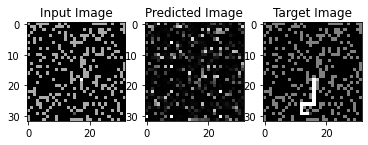

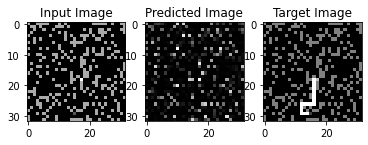

  1%|          | 1/100 [00:04<06:46,  4.10s/it]

Epoch: 0 LossT: 11.471037864685059
Epoch: 0 LossD: 10.936161041259766


 10%|█         | 10/100 [00:40<05:57,  3.97s/it]

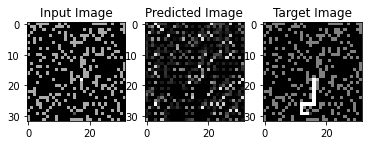

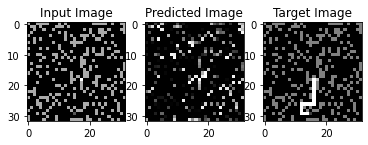

 11%|█         | 11/100 [00:44<06:08,  4.14s/it]

Epoch: 10 LossT: 12.121747016906738
Epoch: 10 LossD: 8.432329177856445


 20%|██        | 20/100 [01:20<05:19,  4.00s/it]

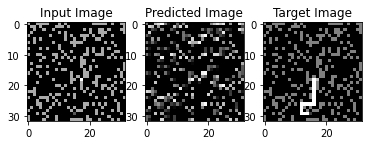

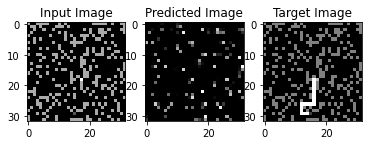

 21%|██        | 21/100 [01:25<05:27,  4.15s/it]

Epoch: 20 LossT: 9.052040100097656
Epoch: 20 LossD: 7.383965015411377


 30%|███       | 30/100 [01:59<04:32,  3.89s/it]

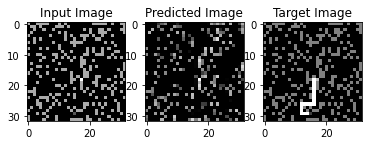

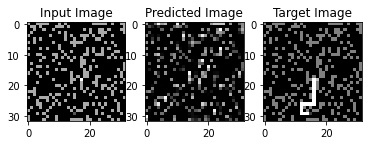

 31%|███       | 31/100 [02:05<05:03,  4.39s/it]

Epoch: 30 LossT: 8.983816146850586
Epoch: 30 LossD: 7.758087158203125


 40%|████      | 40/100 [02:41<04:04,  4.08s/it]

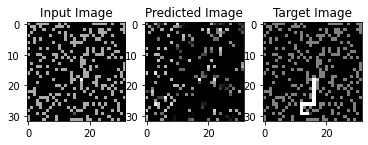

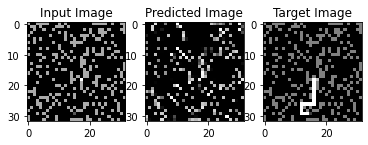

 41%|████      | 41/100 [02:46<04:06,  4.18s/it]

Epoch: 40 LossT: 8.66179084777832
Epoch: 40 LossD: 8.227965354919434


 50%|█████     | 50/100 [03:23<03:24,  4.10s/it]

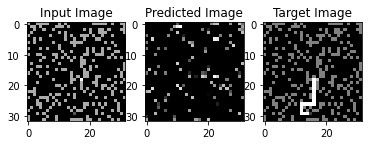

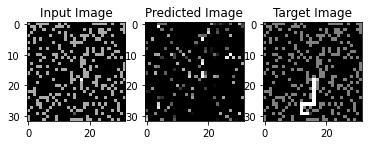

 51%|█████     | 51/100 [03:27<03:30,  4.29s/it]

Epoch: 50 LossT: 9.18976879119873
Epoch: 50 LossD: 7.100619316101074


 53%|█████▎    | 53/100 [03:37<03:12,  4.10s/it]


KeyboardInterrupt: 

In [168]:
train(MazeTransposer,MazeDecoder,x_train,y_train,Epochs,BatchSize,LearningRate,beta1,beta2)

In [169]:
#save the models
T.save(MazeDecoder.state_dict(), 'MazeDecoder.pth')
T.save(MazeTransposer.state_dict(), 'MazeTransposer.pth')